In [164]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import train_test_split
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [205]:
import matplotlib.pyplot as plt
import seaborn as sns

In [97]:
df = pd.read_csv("data/df_main.csv")

## Prepare data

In [98]:
df_day = df.groupby(["day", "weekday","month", "TAVG" ]).count().reset_index()

In [99]:
df_day = df_day[["day", "weekday", "month", "TAVG", "Duration"]]

In [100]:
df_day = df_day.rename(columns={"Duration": "count"})

In [101]:
df_day

,day,weekday,month,TAVG,count
0,2019-01-01,Tuesday,1,12.50,4540
1,2019-01-02,Wednesday,1,6.94,6567
2,2019-01-03,Thursday,1,7.50,7604
3,2019-01-04,Friday,1,4.17,7362
4,2019-01-05,Saturday,1,8.33,5106
...,...,...,...,...,...
360,2019-12-27,Friday,12,6.94,4916
361,2019-12-28,Saturday,12,9.17,6282
362,2019-12-29,Sunday,12,8.89,1409
363,2019-12-30,Monday,12,11.94,5419


### Train-test-split

In [177]:
X_train, X_test, y_train, y_test = train_test_split(df_day.iloc[:,:-1], df_day.iloc[:,-1], test_size=0.33, random_state=42)

In [105]:
#check:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((244, 4), (121, 4), (244,), (121,))

### Feature Engineering

In [178]:
#encode weekends
X_train.loc[(X_train["weekday"] == "Saturday") | (X_train["weekday"] == "Sunday"), "weekend"] = 1

In [179]:
X_train["weekend"] = X_train["weekend"].fillna(0)

In [180]:
# encode public holidays

In [181]:
cal = calendar()
holidays = list(cal.holidays(start=df_day["day"].min(), end=df_day["day"].max()))
holidays = [str(x.date()) for x in holidays]
holidays

['2019-01-01',
 '2019-01-21',
 '2019-02-18',
 '2019-05-27',
 '2019-07-04',
 '2019-09-02',
 '2019-10-14',
 '2019-11-11',
 '2019-11-28',
 '2019-12-25']

In [182]:
X_train.loc[(df_day["day"].isin(holidays)), "holiday"] = 1

In [183]:
X_train["holiday"] = X_train["holiday"].fillna(0)

In [184]:
X_train.set_index("day", inplace=True)

In [185]:
X_train

,weekday,month,TAVG,weekend,holiday
day,,,,,
2019-04-29,Monday,4,11.11,0.0,0.0
2019-02-01,Friday,2,-7.22,0.0,0.0
2019-02-06,Wednesday,2,10.28,0.0,0.0
2019-10-13,Sunday,10,15.00,1.0,0.0
2019-07-01,Monday,7,25.56,0.0,0.0
...,...,...,...,...,...
2019-03-13,Wednesday,3,6.11,0.0,0.0
2019-04-17,Wednesday,4,16.94,0.0,0.0
2019-09-28,Saturday,9,23.06,1.0,0.0


In [186]:
# encode dummies for weekdays 

In [187]:
dummies = pd.get_dummies(X_train['weekday'])

In [188]:
X_train = pd.concat([X_train, dummies.set_index(X_train.index)], axis=1) 

In [189]:
X_train.drop(["Monday", "weekday"], axis=1, inplace=True)

In [190]:
X_train

,month,TAVG,weekend,holiday,Friday,Saturday,Sunday,Thursday,Tuesday,Wednesday
day,,,,,,,,,,
2019-04-29,4,11.11,0.0,0.0,0,0,0,0,0,0
2019-02-01,2,-7.22,0.0,0.0,1,0,0,0,0,0
2019-02-06,2,10.28,0.0,0.0,0,0,0,0,0,1
2019-10-13,10,15.00,1.0,0.0,0,0,1,0,0,0
2019-07-01,7,25.56,0.0,0.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2019-03-13,3,6.11,0.0,0.0,0,0,0,0,0,1
2019-04-17,4,16.94,0.0,0.0,0,0,0,0,0,1
2019-09-28,9,23.06,1.0,0.0,0,1,0,0,0,0


In [ ]:
# Polynomial and interaction Features

In [191]:
poly = PolynomialFeatures(degree=2)
x_poly = poly.fit_transform(X_train[["month", "TAVG"]])
c_names = poly.get_feature_names()
df_poly = pd.DataFrame(x_poly, columns= c_names)

In [192]:
X_train = X_train.reset_index()

In [193]:
X_train = pd.concat([X_train, df_poly], axis=1)

In [194]:
X_train

,day,month,TAVG,weekend,holiday,Friday,Saturday,Sunday,Thursday,Tuesday,Wednesday,1,x0,x1,x0^2,x0 x1,x1^2
0,2019-04-29,4,11.11,0.0,0.0,0,0,0,0,0,0,1.0,4.0,11.11,16.0,44.44,123.4321
1,2019-02-01,2,-7.22,0.0,0.0,1,0,0,0,0,0,1.0,2.0,-7.22,4.0,-14.44,52.1284
2,2019-02-06,2,10.28,0.0,0.0,0,0,0,0,0,1,1.0,2.0,10.28,4.0,20.56,105.6784
3,2019-10-13,10,15.00,1.0,0.0,0,0,1,0,0,0,1.0,10.0,15.00,100.0,150.00,225.0000
4,2019-07-01,7,25.56,0.0,0.0,0,0,0,0,0,0,1.0,7.0,25.56,49.0,178.92,653.3136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,2019-03-13,3,6.11,0.0,0.0,0,0,0,0,0,1,1.0,3.0,6.11,9.0,18.33,37.3321
240,2019-04-17,4,16.94,0.0,0.0,0,0,0,0,0,1,1.0,4.0,16.94,16.0,67.76,286.9636
241,2019-09-28,9,23.06,1.0,0.0,0,1,0,0,0,0,1.0,9.0,23.06,81.0,207.54,531.7636
242,2019-12-15,12,7.50,1.0,0.0,0,0,1,0,0,0,1.0,12.0,7.50,144.0,90.00,56.2500


In [195]:
# Normalization
Scale = MinMaxScaler()
scaled = Scale.fit_transform(X_train[["month", "TAVG", "x0", "x1", "x0^2", "x0 x1", "x1^2"]])

In [196]:
scaled = pd.DataFrame(scaled, columns=["month", "TAVG", "x0", "x1", "x0^2", "x0 x1", "x1^2"])

In [197]:
X_train = X_train.drop(["month", "TAVG", "x0", "x1", "x0^2", "x0 x1", "x1^2"], axis=1)

In [199]:
X_train = pd.concat([X_train, scaled], axis=1)

In [201]:
X_train = X_train.set_index("day")

In [202]:
X_train

,weekend,holiday,Friday,Saturday,Sunday,Thursday,Tuesday,Wednesday,1,month,TAVG,x0,x1,x0^2,x0 x1,x1^2
day,,,,,,,,,,,,,,,,
2019-04-29,0.0,0.0,0,0,0,0,0,0,1.0,0.272727,0.475109,0.272727,0.475109,0.104895,0.201478,0.123064
2019-02-01,0.0,0.0,1,0,0,0,0,0,1.0,0.090909,0.007148,0.090909,0.007148,0.020979,0.000000,0.051973
2019-02-06,0.0,0.0,0,0,0,0,0,1,1.0,0.090909,0.453919,0.090909,0.453919,0.020979,0.119765,0.105363
2019-10-13,1.0,0.0,0,0,1,0,0,0,1.0,0.818182,0.574419,0.818182,0.574419,0.692308,0.562688,0.224330
2019-07-01,0.0,0.0,0,0,0,0,0,0,1.0,0.545455,0.844013,0.545455,0.844013,0.335664,0.661648,0.651367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-13,0.0,0.0,0,0,0,0,0,1,1.0,0.181818,0.347460,0.181818,0.347460,0.055944,0.112134,0.037221
2019-04-17,0.0,0.0,0,0,0,0,0,1,1.0,0.272727,0.623947,0.272727,0.623947,0.104895,0.281276,0.286108
2019-09-28,1.0,0.0,0,1,0,0,0,0,1.0,0.727273,0.780189,0.727273,0.780189,0.559441,0.759581,0.530179


## Models

### Linear Regression with Regularization

In [213]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [228]:
m = Ridge(alpha=0.01) 
m.fit(X_train, y_train)  
m.score(X_train, y_train)

0.7303528298059745

In [229]:
ypred = m.predict(X_train) 
ypred

array([ 9981.78613613,  2256.90768156,  8561.7642194 ,  8939.25963863,
       11765.23161036,  8385.47442736,  9401.41226551, 11804.69877708,
       12321.48415349, 10497.65787111,  7266.14671375, 10701.80635699,
        9999.21103718,  4864.39566584,  5022.10824536, 11518.18293137,
        4141.57194083, 12479.4153693 ,  9529.92927512,  8501.63019167,
       10144.45297521, 10263.38417801, 12503.00358808, 12146.93616916,
       11732.35885793, 11478.82591018, 11871.6597342 , 10386.10257381,
        9349.62202993, 12138.33645873,  9332.08319686, 12037.39979287,
        9311.47256644, 10839.17040195, 10912.69896707,  6873.17134037,
        6867.44622979,  8243.06720457, 11977.30935245, 12137.36331818,
        7445.36365933, 12231.26914196, 11105.04204192, 10084.33524764,
        5517.35853067, 11405.20192941, 10473.15710652,  7745.99519492,
        9001.92680472,  7681.69322045, 12337.18541362,  7516.54190396,
       12357.33453436, 10626.01185034, 11784.60842046,  7811.50339821,
      

In [215]:
mean_squared_error(y_train, ypred)

3080284.412276213

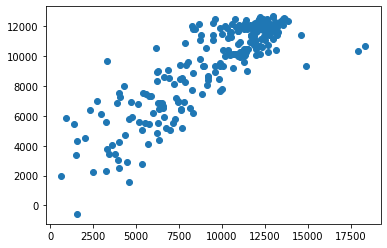

In [231]:
plt.scatter(y_train, ypred)

In [220]:
m.coef_

array([  -247.75582182,   -767.98764429,    675.45652053,    801.73959021,
        -1049.49541207,    409.78396989,    789.82203873,    618.3727443 ,
            0.        ,   9445.05164081,   7398.26111348,   9445.05164082,
         7398.26111348, -19069.18988018,   1895.97116938, -10109.33864432])

###  TEST

In [ ]:
#  make pipeline for feature engineering

## Random Forest

In [232]:
from sklearn.ensemble import RandomForestRegressor

In [233]:
rf = RandomForestRegressor(max_depth=7)

In [234]:
rf.fit(X_train, y_train)  
rf.score(X_train, y_train.values.ravel())

0.9012647017242016

In [ ]:
## Hyperparameter Optimization

In [ ]:
#split train/test set
from sklearn.model_selection import train_test_split

In [ ]:
Xtrain_forest, Xtest_forest, ytrain_forest, ytest_forest = train_test_split(Xtrain, ytrain, test_size=0.3, random_state=42)
Xtrain_forest.shape, ytrain_forest.shape

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {
    'max_depth': [6, 8, 16],
    'n_estimators': [10, 100, 200]
}
param_grid

In [ ]:
cv = GridSearchCV(rf, param_grid, 
                  return_train_score=True,
                  cv=2, n_jobs=4)

forest=cv.fit(Xtrain_forest, ytrain_forest)

ypred_forest=forest.predict(Xtest_forest)
forest.score(Xtest_forest,ytest_forest)

In [ ]:
cv.best_estimator_

## Gradient Descent

In [ ]:
temp = df[['temp_scaled', 'count']]

# Building the model
a = 100
b = 200

learning_rate = 0.01
max_iterations = 15000  
threshold = 0.01

n = temp['count'].count()

In [ ]:
# applying Gradient Descent 
for i in range(max_iterations): 
    temp['count_pred'] = temp['temp_scaled']*b + a    # temp_scaled = xtrain, count_pred = ypred
    derivative_a = (-2/n) * sum(temp['count'] - temp['count_pred'])  # derivative of loss function
    derivative_b = (-2/n) * sum((temp['count'] - temp['count_pred'])*temp['temp_scaled'])
    mse = 1/n*sum((temp['count'] - temp['count_pred'])**2)
    grad_norm = np.sqrt(derivative_a**2 + derivative_b**2)   #???
    if grad_norm <= threshold:
        print (a, b, mse, 'threshold reached')
        break
      
    a = a - learning_rate * derivative_a  # Update a
    b = b - learning_rate * derivative_b  # Update b
    
    if i % 100 == 0:
        print (i, a, b, mse, grad_norm)

In [ ]:
derivative_a